In [1]:
import os
import random
import warnings
from PIL import Image
from PGGAN import *
# from normalizer import DataNormalizer
import torch.optim as optim
import torch.backends.cudnn as cudnn
# import torchvision.utils as vutils

import torch.utils.data as udata
# import torchvision.datasets as vdatasets
# import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
# import h5py 
import matplotlib.pyplot as plt


Create Network
Cursor 0 256 256
Cursor 1 256 256
Cursor 2 256 256
Cursor 3 256 256
Cursor 4 256 128
Cursor 5 128 64
Cursor 6 64 32
Cursor 7 32 32
Cursor 6 32 64
Cursor 5 64 128
Cursor 4 128 256
Cursor 3 256 256
Cursor 2 256 256
Cursor 1 256 256
Generator(
  (lod_layers_): ModuleList(
    (0): Sequential(
      (0): PixelWiseNormLayer()
      (1): Conv2d(264, 256, kernel_size=(2, 16), stride=(1, 1), padding=(1, 15), bias=False)
      (2): EqualizedLearningRateLayer(
        (layer_): Conv2d(264, 256, kernel_size=(2, 16), stride=(1, 1), padding=(1, 15), bias=False)
      )
      (3): LeakyReLU(negative_slope=0.2)
      (4): PixelWiseNormLayer()
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (6): EqualizedLearningRateLayer(
        (layer_): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (7): LeakyReLU(negative_slope=0.2)
      (8): PixelWiseNormLayer()
    )
    (1): Sequential(
      (0): Up

load 4000th file
Resolution:32x1024, Status:stable, Cur_step:0, Batch_id:0, D_loss:15.19184398651123, W_D:-0.000584971159696579, M_fake:-0.011747450567781925, M_Real:-0.009742895141243935, GP:0.5192216634750366, Real_P_Loss:2.079576015472412, Fake_P_Loss:9.999042510986328, G_loss:20.80750846862793, Net_alpha:1.0
Resolution:32x1024, Status:stable, Cur_step:0, Batch_id:200, D_loss:-19.0687255859375, W_D:21.598112106323242, M_fake:-10.517147064208984, M_Real:11.080965042114258, GP:0.21133358776569366, Real_P_Loss:5.553653717041016, Fake_P_Loss:0.4160499572753906, G_loss:29.01045036315918, Net_alpha:1.0
Resolution:32x1024, Status:stable, Cur_step:0, Batch_id:400, D_loss:-15.15926742553711, W_D:36.09223937988281, M_fake:50.088645935058594, M_Real:86.1808853149414, GP:-0.040296196937561035, Real_P_Loss:4.117016315460205, Fake_P_Loss:21.335933685302734, G_loss:-1.4020538330078125, Net_alpha:1.0
Resolution:32x1024, Status:stable, Cur_step:0, Batch_id:600, D_loss:-31.315006256103516, W_D:52.107

Resolution:32x1024, Status:stable, Cur_step:0, Batch_id:5600, D_loss:-269.2777404785156, W_D:342.17999267578125, M_fake:18.624042510986328, M_Real:360.8040466308594, GP:-1.8649191856384277, Real_P_Loss:1.7376768589019775, Fake_P_Loss:91.55144500732422, G_loss:49.6914176940918, Net_alpha:1.0
Resolution:32x1024, Status:stable, Cur_step:0, Batch_id:5800, D_loss:-317.2494201660156, W_D:398.2268371582031, M_fake:28.41061782836914, M_Real:426.637451171875, GP:-0.4257405400276184, Real_P_Loss:1.709075689315796, Fake_P_Loss:85.23483276367188, G_loss:24.947792053222656, Net_alpha:1.0
load 25904th file
Resolution:32x1024, Status:stable, Cur_step:0, Batch_id:6000, D_loss:-225.1695098876953, W_D:313.42108154296875, M_fake:59.636287689208984, M_Real:373.3753967285156, GP:-0.14718350768089294, Real_P_Loss:23.55856704711914, Fake_P_Loss:89.72340393066406, G_loss:175.94937133789062, Net_alpha:1.0
Resolution:32x1024, Status:stable, Cur_step:0, Batch_id:6200, D_loss:-310.981201171875, W_D:360.6044311523

RuntimeError: The size of tensor a (512) must match the size of tensor b (1024) at non-singleton dimension 3

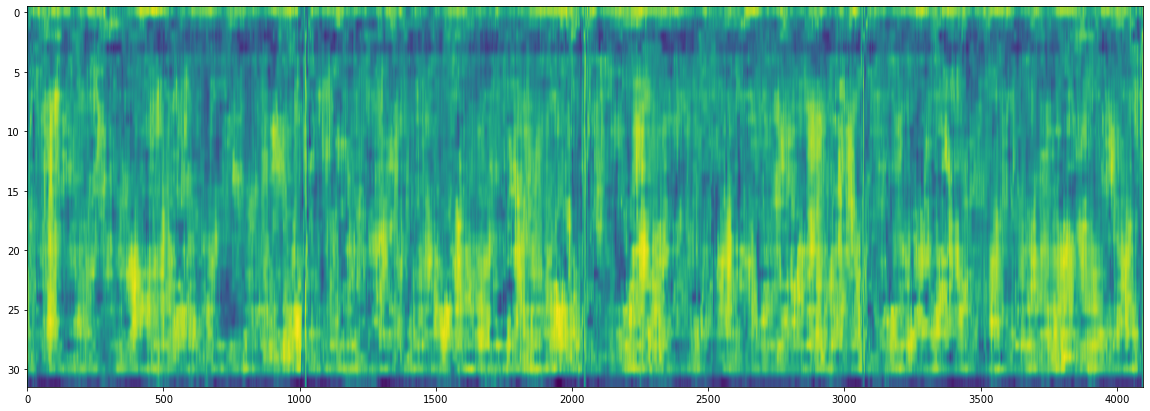

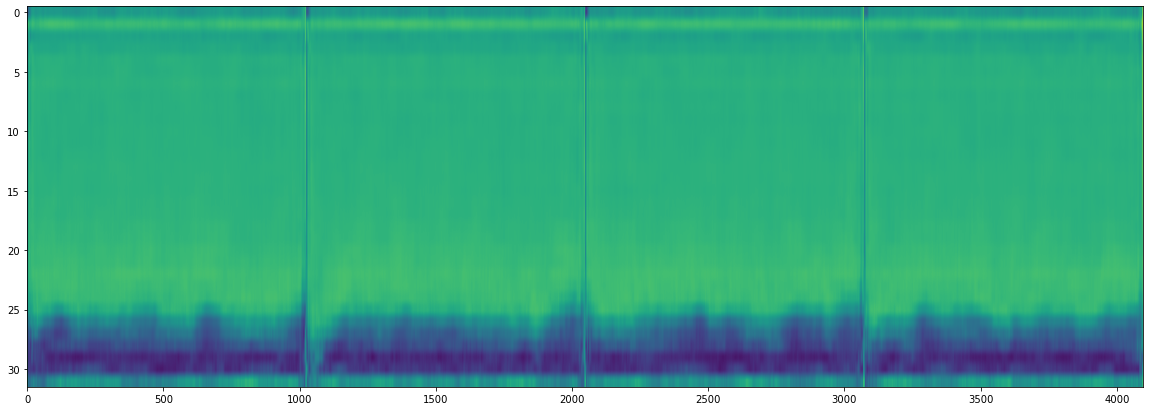

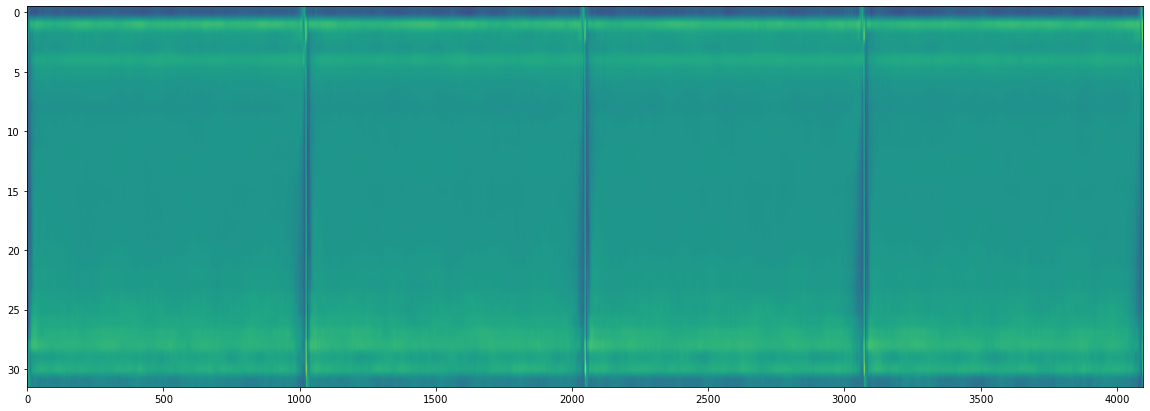

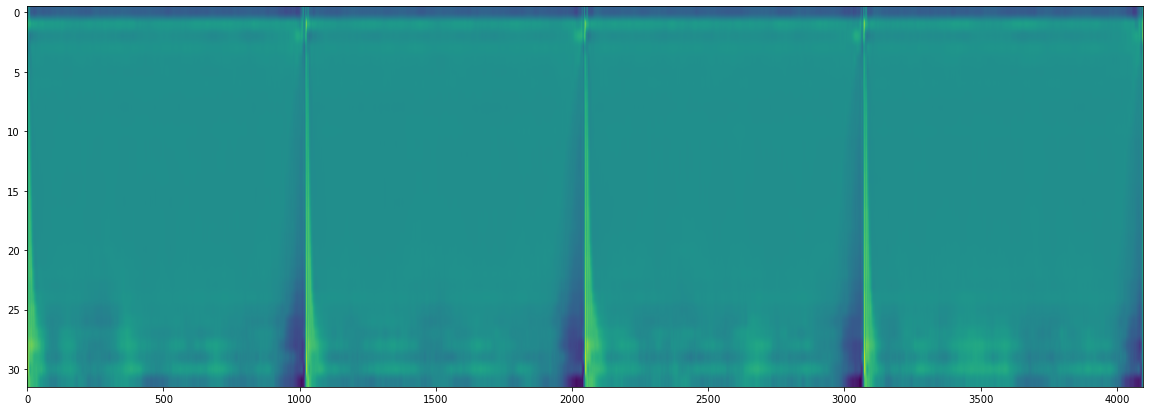

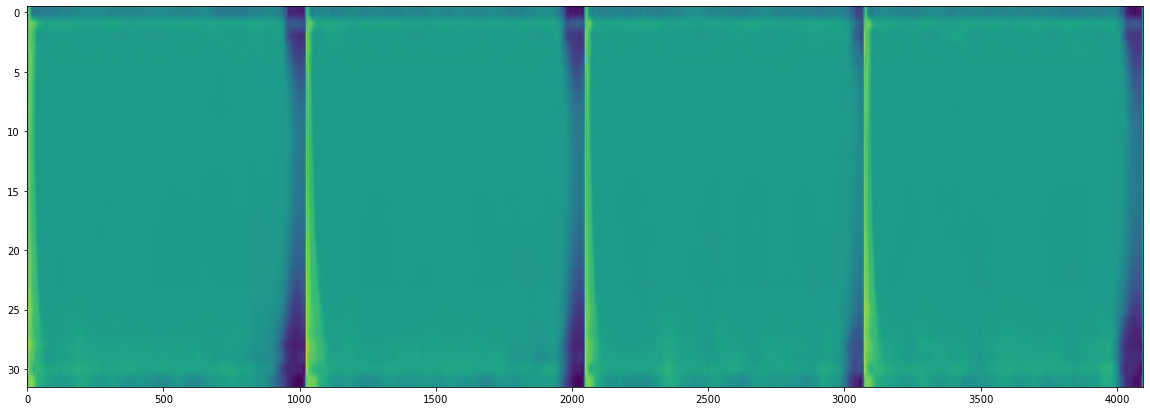

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

"""BATCH_SIZE 수정 ㄴㄴ 16까진 ㅇㅋ"""
folder ='../train_making'
BATCH_SIZE= 4
DEVICE = torch.device("cuda")
G_LR = 2e-4
D_LR = 4e-4
ADAM_BETA = (0.0, 0.99)
ADAM_EPS = 1e-8
LAMBDA_FOR_WGANGP = 1
CRITIC_FOR_WGANGP = 1

TOTAL_DATA_SIZE=25904 #validation Nsynth dataset size. If use trainingset, this argument should be changed


        
class PGGAN(object):
    def __init__(self,
#                  resolution,            # Resolution.
                 latent_size,           # Dimensionality of the latent vectors.
#                  dataloader,
                 criterion_type="GAN",  # ["GAN", "WGAN-GP"]
                 rgb_channel=4,         # Output channel size, for rgb always 3
                 fmap_base=2 ** 11,     # Overall multiplier for the number of feature maps.
                 fmap_decay=1.0,        # log2 feature map reduction when doubling the resolution.
                 fmap_max=2 ** 6,       # Maximum number of feature maps in any layer.
                 is_tanh=True,
                 is_sigmoid=True
                 ):
#         self.dataloader=dataloader
        self.latent_size_ = latent_size
        self.rgb_channel_ = rgb_channel
        self.fmap_base_ = fmap_base
        self.fmap_decay_ = fmap_decay
        self.fmap_max_ = fmap_max
        
        # self.stable_and_fadein_step = [6, 6, 6, 6, 6, 6, 30]
        self.stable_and_fadein_step = [1,1,1,1,1,1,1]



        self.criterion_type_ = criterion_type
        self.is_tanh_ = is_tanh
        self.is_sigmoid_ = False if self.criterion_type_ in ["WGAN-GP"] else is_sigmoid

        self.gradient_weight_real_ = torch.FloatTensor([-1]).cuda()
        self.gradient_weight_fake_ = torch.FloatTensor([1]).cuda()

    
#         self.init_data_normalizer()
        self._init_network()
        self.avg_layer = torch.nn.AvgPool2d((2,2),stride=(2,2))
    
    
        
    def range_normalizer(self, train_loader, magnitude_margin, IF_margin):
        min_spec = 10000
        max_spec = -10000
        min_IF = 10000
        max_IF = -10000

        for batch_idx, (pitch_label, mel_spec, mel_IF) in enumerate(train_loader): 
            
            mel_spec_L = torch.transpose(mel_spec,0,1)[0]
            mel_spec_R = torch.transpose(mel_spec,0,1)[1]
            mel_IF_L = torch.transpose(mel_IF,0,1)[0]
            mel_IF_R = torch.transpose(mel_IF,0,1)[1]
            
            spec_L = mel_spec_L
            IF_L = mel_IF_L
            spec_R = mel_spec_R
            IF_R = mel_IF_R

            if spec_L.min() < min_spec: min_spec=spec_L.min()
            if spec_R.min() < min_spec: min_spec=spec_R.min()
            if spec_L.max() > max_spec: max_spec=spec_L.max()
            if spec_R.max() > max_spec: max_spec=spec_R.max()

            if IF_L.min() < min_IF: min_IF=IF_L.min()
            if IF_R.min() < min_IF: min_IF=IF_R.min()
            if IF_L.max() > max_IF: max_IF=IF_L.max()
            if IF_R.max() > max_IF: max_IF=IF_R.max()

        self.s_a = magnitude_margin * (2.0 / (max_spec - min_spec))
        self.s_b = magnitude_margin * (-2.0 * min_spec / (max_spec - min_spec) - 1.0)
        
        self.p_a = IF_margin * (2.0 / (max_IF - min_IF))
        self.p_b = IF_margin * (-2.0 * min_IF / (max_IF - min_IF) - 1.0)
    
    def normalize(self, feature_map):
        a = np.asarray([self.s_a, self.p_a, self.s_a, self.p_a])[None, :, None, None]
        b = np.asarray([self.s_b, self.p_b, self.s_b, self.p_b])[None, :, None, None]
        a = torch.FloatTensor(a).cuda()
        b = torch.FloatTensor(b).cuda()
        feature_map = feature_map *a + b
        return feature_map
    
    def train(self):
        
        self._init_optimizer()
        self._init_criterion()
        
        # Declare Model status
        net_level = 0
        net_status = "stable"
        net_alpha = 1.0
        
        
        for cur_level in range(7):
            self.stable_steps = self.stable_and_fadein_step[cur_level]
            self.fadein_steps = self.stable_and_fadein_step[cur_level] 

            if cur_level==6:
                # 이거 배치 사이즈 바꾸고 하는게 아무것도 없는데?
#                 self.dataloader.change_batch_size(batch_size=4)
                self.stable_steps = 100
                
            if cur_level ==0:
                net_status == "stable"
                for step in range(self.stable_steps):
                    self._train(cur_level, net_status, net_alpha, step)
            else:
                net_status = "fadein"
                
                for step in range(self.fadein_steps):
#                     net_alpha = 1.0 - (step + 1) / fadein_steps
                    self._train(cur_level, "fadein", net_alpha, step)
                    
                for step in range(self.stable_steps*2):
                    net_alpha = 1.0
                    self._train(cur_level, "stable", net_alpha, step)
                    if cur_level ==6:
                        torch.save(self.g_net.state_dict(), folder + '/Gnet_%dx%d_step%d.pth' % (2 ** (cur_level + 1), 2 ** (cur_level + 4), step))
                        torch.save(self.d_net.state_dict(), folder + '/Dnet_%dx%d_step%d.pth' % (2 ** (cur_level + 1), 2 ** (cur_level + 4), step))
            torch.save(self.g_net.state_dict(), folder + '/Gnet_%dx%d.pth' % (2 ** (cur_level + 1), 2 ** (cur_level + 4)))
            torch.save(self.d_net.state_dict(), folder + '/Dnet_%dx%d.pth' % (2 ** (cur_level + 1), 2 ** (cur_level + 4)))


    def _train(self, net_level, net_status, net_alpha, cur_step):
            
#         current_level_res = 2 ** (net_level + 1)
        current_level_res = 2 ** (5)
        batch_idx = 0
        batch_cnt = 0
        """for문 돌려서 여기다가 dataloader = data_loader 호출해서 돌릴 것"""
        while batch_idx < int(TOTAL_DATA_SIZE/BATCH_SIZE):
#         for batch_idx in range(int(TOTAL_DATA_SIZE/BATCH_SIZE)):
            if batch_idx == (24000/BATCH_SIZE):
                train_loader = udata.DataLoader(udata.TensorDataset(
                                    torch.Tensor(np.load('../np_array_LR/'+'pitch_list_'+ str(TOTAL_DATA_SIZE) + '.npy')),
                                    torch.Tensor(np.load('../np_array_LR/'+'mel_spec_list_' + str(TOTAL_DATA_SIZE) + '.npy')),
                                    torch.Tensor(np.load('../np_array_LR/'+'mel_IF_list_' + str(TOTAL_DATA_SIZE) + '.npy'))
                                           ), batch_size=BATCH_SIZE, shuffle=True)
                print("load {}th file".format(TOTAL_DATA_SIZE))
                self.range_normalizer(train_loader, magnitude_margin=0.8, IF_margin=1.0)
                
            elif batch_idx % (4000/BATCH_SIZE) == 0:
                train_loader = udata.DataLoader(udata.TensorDataset(
                                    torch.Tensor(np.load('../np_array_LR/'+'pitch_list_'+ str(batch_idx*BATCH_SIZE+4000) + '.npy')),
                                    torch.Tensor(np.load('../np_array_LR/'+'mel_spec_list_' + str(batch_idx*BATCH_SIZE+4000) + '.npy')),
                                    torch.Tensor(np.load('../np_array_LR/'+'mel_IF_list_' + str(batch_idx*BATCH_SIZE+4000) + '.npy'))
                                           ), batch_size=BATCH_SIZE, shuffle=True)
                print("load {}th file".format((batch_idx*BATCH_SIZE+4000)))
                self.range_normalizer(train_loader, magnitude_margin=0.8, IF_margin=1.0)
                
        
        # for batch_idx, (score, target_spectrum, IF) in enumerate(self.dataloader.train_loader): 
#         for batch_idx, (spec, IF, pitch_label, mel_spec, mel_IF) in enumerate(self.dataloader.train_loader): 
            for batch_idx2, (pitch_label, mel_spec, mel_IF) in enumerate(train_loader):        

                # train mel spec IF
                mel_spec_L = torch.transpose(mel_spec,0,1)[0]
                mel_spec_R = torch.transpose(mel_spec,0,1)[1]
                mel_IF_L = torch.transpose(mel_IF,0,1)[0]
                mel_IF_R = torch.transpose(mel_IF,0,1)[1]
                
                spec_L = mel_spec_L
                IF_L = mel_IF_L
                spec_R = mel_spec_R
                IF_R = mel_IF_R

                stack_real_image = torch.stack((spec_L,IF_L,spec_R,IF_R),dim=1).cuda()
                
                
                stack_real_image = torch.transpose(stack_real_image,2,3)

                little_batch_size = spec_L.size()[0]

#                 while stack_real_image.size()[2] != current_level_res:
#                     stack_real_image = self.avg_layer(stack_real_image)
                    
#                 stack_real_image = stack_real_image.cuda(0)
                stack_real_image = stack_real_image.cuda()

                if net_status =='stable':
                    net_alpha = 1.0
                elif net_status =='fadein':

                    if little_batch_size==BATCH_SIZE:
                        net_alpha = 1.0 - (cur_step * TOTAL_DATA_SIZE + batch_idx * little_batch_size) / (self.fadein_steps * TOTAL_DATA_SIZE)
                    else:
                        net_alpha = 1.0 - (cur_step * TOTAL_DATA_SIZE + batch_idx*(BATCH_SIZE) + little_batch_size) / (self.fadein_steps * TOTAL_DATA_SIZE)

                if net_alpha< 0.0:
                    print("Alpha too small <0")
                    return 

                # change net status 
                self.g_net.net_config = [net_level, net_status, net_alpha]
                self.d_net.net_config = [net_level, net_status, net_alpha]

                """ Make Fake Condition Vector """
                pitch_label = pitch_label.cuda()

                
                fake_pitch_label = torch.LongTensor(little_batch_size, 1).random_() % 8
    #             fake_pitch_label = torch.LongTensor(little_batch_size, 1).random_() % 128            
                fake_one_hot_pitch_condition_vector = torch.zeros(little_batch_size, 8).scatter_(1, fake_pitch_label, 1).unsqueeze(2).unsqueeze(3).cuda()
                fake_pitch_label = fake_pitch_label.cuda().squeeze()

# 여기서 batch = 1 일 때 문제 생기던데 squeeze 되면서 디멘션 다 날아가는 것 처럼 보임

                """ generate random vector """
                fake_seed = torch.randn(little_batch_size, self.latent_size_, 1, 1).cuda()
                fake_seed_and_pitch_condition = torch.cat((fake_seed, fake_one_hot_pitch_condition_vector), dim=1)
               
                fake_generated_sample = self.g_net(fake_seed_and_pitch_condition)
                
                stack_real_image = self.normalize(stack_real_image)
                
                pitch_real, d_real = self.d_net(stack_real_image)
                pitch_fake, d_fake  = self.d_net(fake_generated_sample.detach())


                # WGAN-GP
                """ update d_net """
                # real:-1 fake:1
                for p in self.d_net.parameters():
                    p.requires_grad = True 
                self.d_net.zero_grad()


                # Train D with Real 
                mean_real = d_real.mean() # wgan loss 
                # mean_real = nn.ReLU()(1.0 - d_real).mean() #hinge loss


                # Train D with Fake 
                mean_fake = d_fake.mean() # wgan loss
                # mean_fake = nn.ReLU()(1.0 + d_fake).mean() # hinge loss


                # Train D with GP 
                gradient_penalty = 10 * self._gradient_penalty(stack_real_image.data, fake_generated_sample.data, little_batch_size, current_level_res)


                # Train D with classifier Loss
                
                pitch_label = pitch_label.long()
#                 fake_pitch_label = fake_pitch_label.long()

                real_pitch_loss = self.NLL_loss(pitch_real, pitch_label)
                fake_pitch_loss = self.NLL_loss(pitch_fake, fake_pitch_label)
                p_loss = 10 *(real_pitch_loss)

                
                # D_loss = mean_fake + mean_real + gradient_penalty + p_loss # hinge
                D_loss = mean_fake - mean_real + gradient_penalty + p_loss # wgan-gp
                Wasserstein_D = mean_real - mean_fake

                D_loss.backward()
                self.d_optim.step()

                if batch_idx % 3 == 0: # avoid Mode Collpase which caused by strong Generator

                    """ update g_net """
                    for p in self.d_net.parameters():
                        p.requires_grad = False  # to avoid computation
                    self.g_net.zero_grad()
                    
                    pitch_fake, d_fake = self.d_net(fake_generated_sample)
                    mean_fake = d_fake.mean()

                    fake_pitch_loss = self.NLL_loss(pitch_fake, fake_pitch_label)
                    timed_fake_pitch_loss = 10 *fake_pitch_loss
                    G_loss = -mean_fake + timed_fake_pitch_loss
                    G_loss.backward()



                self.g_optim.step()
                if batch_idx %1400 ==0:
                    self.generate_picture(fake_generated_sample[:,0,:,:], current_level_res, cur_step, batch_idx, net_status)
                if batch_idx %200==0:
                    print("Resolution:{}x{}, Status:{}, Cur_step:{}, Batch_id:{}, D_loss:{}, W_D:{}, M_fake:{}, M_Real:{}, GP:{}, Real_P_Loss:{}, Fake_P_Loss:{}, G_loss:{}, Net_alpha:{}".format(\
                            current_level_res, current_level_res*(2**5), net_status, cur_step, batch_idx, D_loss, Wasserstein_D, mean_fake, mean_real, real_pitch_loss, fake_pitch_loss, gradient_penalty, G_loss, net_alpha))

                batch_idx = batch_cnt*int(4000/BATCH_SIZE) + batch_idx2 + 1
                if batch_idx2 == int(4000/BATCH_SIZE) - 1:
                    batch_cnt = batch_cnt + 1
#                 print(batch_idx, batch_idx2)
                
        print("self.fadein_steps",self.fadein_steps* TOTAL_DATA_SIZE,\
              "cur_step",(cur_step * TOTAL_DATA_SIZE + batch_idx * little_batch_size),\
              "net_alpha",net_alpha
              )
        
        
    def generate_picture(self, spec, resolution, step, batch_idx, status):
        spec = spec.data.cpu().numpy()
        stack_spec = np.hstack((spec[0],spec[1],spec[2],spec[3]))
        flip_stack = np.flipud(stack_spec)
        fig = plt.figure(figsize=(20,7))
        plt.imshow(stack_spec,aspect='auto')
        
        plt.savefig( folder + "/{}_{}_{}_{}_{}_sample.png".format(resolution, resolution*(2**5), status, step, batch_idx ))
    
    

    def _init_criterion(self):
        
        self.criterion = self._gradient_penalty
        self.NLL_loss = nn.NLLLoss()
           
#     def init_data_normalizer(self):
#         self.data_normalizer = DataNormalizer(self.dataloader)

    def _init_network(self):
        # Init Generator and Discriminator
        print("Create Network")
        self.g_net = Generator(256, self.latent_size_, self.rgb_channel_,
                                is_tanh=self.is_tanh_, channel_list=[256,256,256,256,256,128,64,32])
        self.d_net = Discriminator(256, self.rgb_channel_,
                                   is_sigmoid=self.is_sigmoid_, channel_list=[256,256,256,256,128,64,32,32])
        # if TO_GPU:
        self.g_net.cuda(0)
        self.d_net.cuda(0)
        print(self.g_net)
        print(self.d_net)
        
        
    def _init_optimizer(self):
        self.g_optim = optim.Adam(self.g_net.parameters(), lr=G_LR, betas=ADAM_BETA, eps=ADAM_EPS)
        self.d_optim = optim.Adam(self.d_net.parameters(), lr=D_LR, betas=ADAM_BETA, eps=ADAM_EPS)
        
    def _gradient_penalty(self, real_data, fake_data, batch_size, res):
        """
        This algorithm was mentioned on the Page4 of paper
        'Improved Training of Wasserstein GANs'
        This implementation was from 'https://github.com/caogang/wgan-gp'
        """
        
        # print("real_data.nelement() / batch_size",real_data.nelement() / batch_size)
        epsilon = torch.rand(batch_size, 1)
        
        epsilon = epsilon.expand(batch_size, int(real_data.nelement() / batch_size)).contiguous().view(batch_size, 4, res, res*(2**5))
#         epsilon = epsilon.expand_as(real_data)
#         print("epsilon",epsilon.size())
        epsilon = epsilon.cuda()
        median_x = epsilon * real_data + ((1 - epsilon) * fake_data)

        # if TO_GPU:
        median_x = median_x.cuda()
        median_data = torch.autograd.Variable(median_x, requires_grad=True)

        _, d_median_data = self.d_net(median_data)

        gradients = torch.autograd.grad(outputs=d_median_data, inputs=median_data,
                                        grad_outputs=torch.ones(d_median_data.size()).cuda(),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA_FOR_WGANGP
        return gradient_penalty




def main():    
#     dataloader = NsynthDataLoader()
#     p = PGGAN(512, 256, criterion_type="WGAN-GP")
    p = PGGAN(256, criterion_type="WGAN-GP")

    p.train()   


if __name__ == "__main__":
    main()
